1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy import optimize

In [7]:
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
sort_max_speeds = np.sort(max_speeds)

In [11]:
cprob = (np.arange(1, years_nb + 1))/(years_nb + 1)

In [12]:
quantile_func = UnivariateSpline(cprob, sorted_max_speeds)

In [16]:
nprob = np.linspace(0, 1, 100) 
fitted_max_speeds = quantile_func(nprob)

In [17]:
fifty_prob = 1. - 0.02
fifty_wind = quantile_func(fifty_prob)
fifty_wind

array(32.97989844)

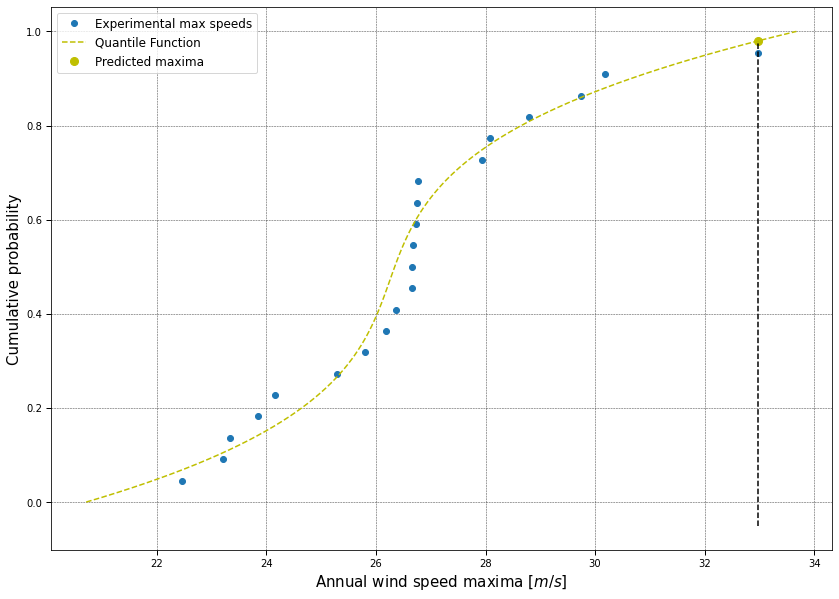

In [39]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(sorted_max_speeds, cprob, 'o', label = 'Experimental max speeds')
ax.plot(fitted_max_speeds, nprob, 'y--', label = 'Quantile Function')
ax.plot([fifty_wind], [fifty_prob], 'o', ms=8., mfc='y', mec='y', label = 'Predicted maxima')
ax.plot([fifty_wind, fifty_wind], [plt.axis()[2], fifty_prob], 'k--')
ax.set_xlabel('Annual wind speed maxima [$m/s$]', size = 15)
ax.set_ylabel('Cumulative probability', size = 15)
ax.tick_params(which='major', width=1.0)
ax.tick_params(which='major', length=5)
ax.legend(prop = {'size' : 12})
ax.grid(linestyle="--", linewidth=0.5, color='.25', zorder=-10)

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

In [4]:
tmax = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
tmin = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

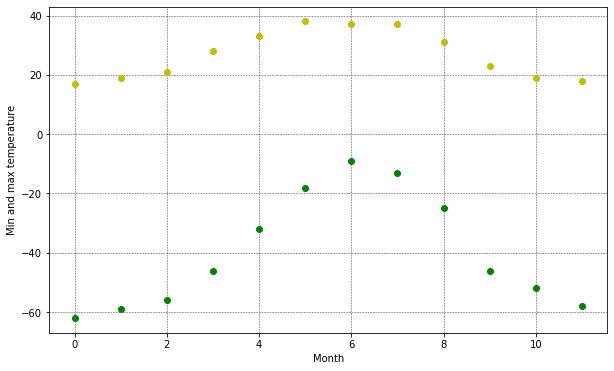

In [5]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ms = np.arange(12)
ax1.plot(ms, tmax, 'yo')
ax1.plot(ms, tmin, 'go')
ax1.set_xlabel('Month')
ax1.set_ylabel('Min and max temperature')
ax1.grid(linestyle="--", linewidth=0.5, color='.25', zorder=-5)

to define a function that describes min and max temperatures, by looking at the graph I decided to go with a periodic 
function. I started with the cosinus of $(t+t_{off})$ that is obviously not enough, since the periodicity is too small and doesn't fit the experimental points. The needed periodicity is $12$ (the number of months) and so $L = 12 = (2*\pi)/k$ with $L$ period and $k$ the factor that multiplies the argument of the cosinus. So it will be something like $A*cos(2*\pi*(t+t_{off})/12)$.

In [26]:
def yt(t, y, A, t_off):
     return (y + A*np.cos(2*np.pi*(t+t_off)/12))
res_max, cov_max = optimize.curve_fit(yt, ms, tmax, [18, 10, 0])
res_min, cov_min = optimize.curve_fit(yt, ms, tmin, [-60, 20, 0])

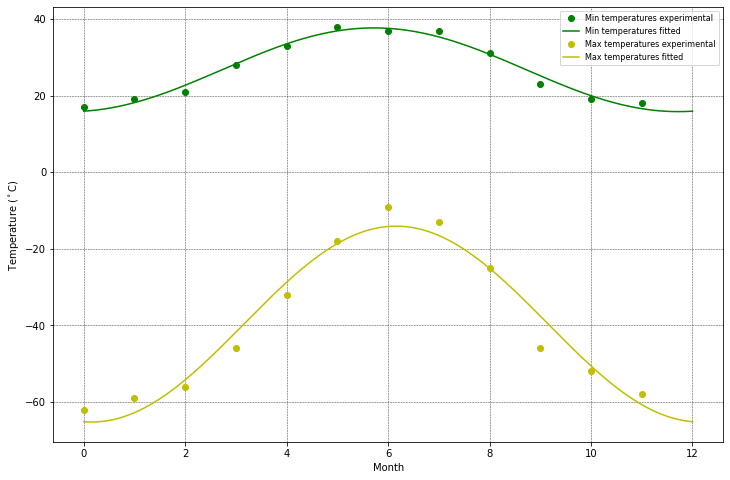

In [41]:
days = np.linspace(0, 12, num = 365)
fig, ax2 = plt.subplots(figsize=(12, 8))
ax2.plot(ms, tmax, 'go', label = 'Min temperatures experimental')
ax2.plot(days, yt(days, *res_max), 'g-', label = 'Min temperatures fitted')
ax2.plot(ms, tmin, 'yo', label = 'Max temperatures experimental')
ax2.plot(days, yt(days, *res_min), 'y-', label = 'Max temperatures fitted')
ax2.set_xlabel('Month')
ax2.set_ylabel('Temperature ($^\circ$C)')
ax2.legend(prop = {'size' : 8})
ax2.grid(linestyle="--", linewidth=0.5, color='.25', zorder=-10)
plt.show()

The fit is reasonable, by setting the period to T = 12 one obtain a function with a desired periodicity. If one changes the period to 11 or 10 it can be seen that by looking at it the fit is better in the central region but the function is already starting to grow again by the time it reaches the last points, which is not desired. 

In [36]:
print(res_max[2], res_min[2])
print(res_max[0], res_min[0])

0.2765199651166734 -0.15603635626150134
26.750000000023547 -39.666666660747126


By considering that on the $x\ axis$ we have the whole year in days, if every unit is a month, a day is approximately $0.0329$. So to have a better undestanding of what the time offset is I converted it into a number of days, which is $8$ days to the right for the maxtemp and $5$ days to the left for the mintemp. So by using this proportion the offset between the two curves is of $13$ days. <br>
They both peak in june, as you would expect by experimental data, with the peak of the maxtemp slightly moved to the right, more in between june and july. 

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


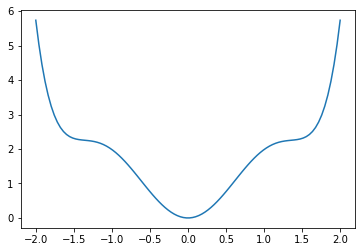

In [3]:
def sixh(x): 
    return (4. - 2.1*x[0]**2 + (x[0]**4)/3)*x[0]**2 + x[0]*x[1] + (4*x[1]**2 - 4)*x[1]**2
x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)
plt.plot(x, sixh([x, y])) # visualize a projection of tthe function

In [4]:
xg, yg = np.meshgrid(x, y)

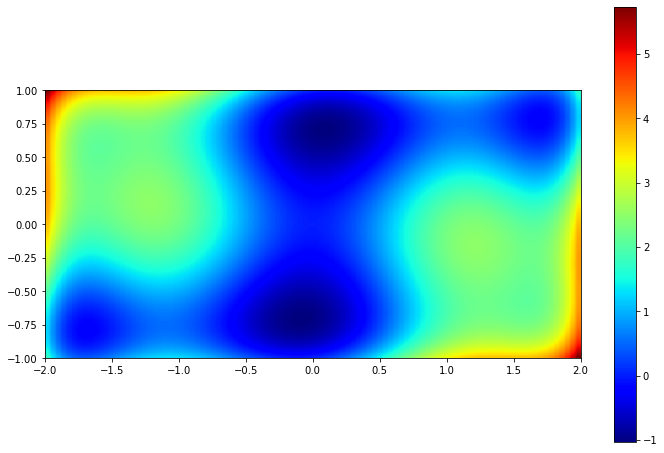

In [5]:
fig = plt.figure(figsize=(12, 8))
plt.imshow(sixh([xg, yg]), extent=[-2, 2, -1, 1], cmap = 'jet')
plt.colorbar()

In [16]:
min1 = optimize.minimize(sixh, x0=[0, -0.75])
min2 = optimize.minimize(sixh, x0=[0, 0.75])
print('The coordinates of the first global minima are {}'.format(min1.x))
print('The coordinates of the second global minima are {}'.format(min2.x))

The coordinates of the first global minima are [ 0.08984201 -0.71265641]
The coordinates of the second global minima are [-0.08984201  0.71265641]


Now, trying variouse methods: 

In [14]:
method = ['Powell', 'CG', 'BFGS', 'Nelder-Mead', 'L-BFGS-B', 'TNC']
mi1 = [optimize.minimize(sixh, x0=[0, -0.75], method = method[i]) for i in range(6)]
mi2 = [optimize.minimize(sixh, x0=[0, +0.75], method = method[i]) for i in range(6)]
for i in range(6):
    print('By using the {} method the global minima coordinates are {} and {}'.format(method[i], mi1[i].x, mi2[i].x))

By using the Powell method the global minima coordinates are [ 0.08987277 -0.71265816] and [-0.08986384  0.71265729]
By using the CG method the global minima coordinates are [ 0.08984201 -0.7126564 ] and [-0.08984201  0.7126564 ]
By using the BFGS method the global minima coordinates are [ 0.08984201 -0.71265641] and [-0.08984201  0.71265641]
By using the Nelder-Mead method the global minima coordinates are [ 0.08985543 -0.71264841] and [-0.08986417  0.71266077]
By using the L-BFGS-B method the global minima coordinates are [ 0.08984187 -0.71265637] and [-0.08984187  0.71265637]
By using the TNC method the global minima coordinates are [ 0.08984227 -0.71265642] and [-0.08985474  0.71267024]


There are 2 global minima and the function value at those points is: 

In [20]:
print(sixh(min1.x))
print(sixh(min2.x))

-1.0316284534898772
-1.031628453489877


For an initial guess of (𝑥,𝑦) = (0,0), what happens is that the optimize.minimize() method returns the local maxima located at (0,0) and fails to find the actual minima.

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

In [2]:
from scipy import fftpack

In [3]:
pop = np.loadtxt("populations.txt")
y = pop[:,0] #year
h = pop[:,1] #hares
l = pop[:,2] #lynxes

Text(0, 0.5, 'Power')

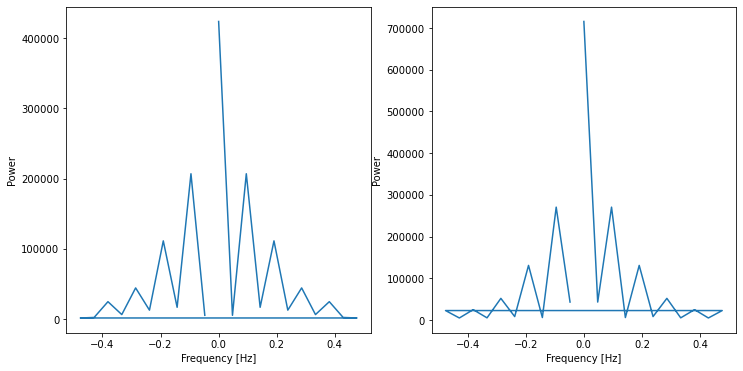

In [4]:
l_fft = fftpack.fft(l)
h_fft = fftpack.fft(h)
l_freq = fftpack.fftfreq(l.size, d=1.)
h_freq = fftpack.fftfreq(h.size, d=1.)
l_power = np.abs(l_fft)
h_power = np.abs(h_fft)
# Plot the FFT power
figure, (ax1, ax2) = plt.subplots(nrows = 1, ncols =2, figsize = (12,6))
ax1.plot(l_freq, l_power)
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Power')
ax2.plot(h_freq, h_power)
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Power')

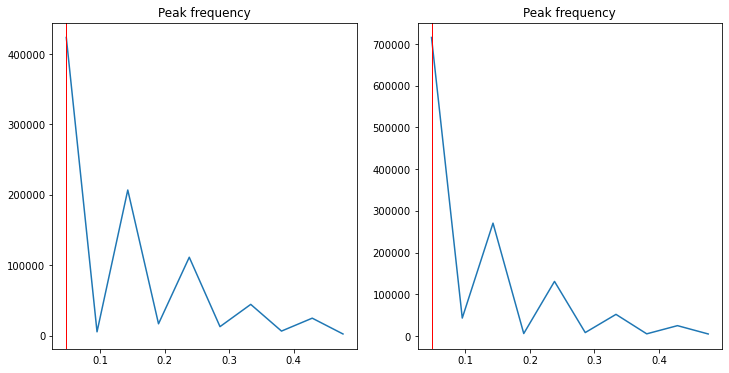

In [5]:
figure, (ax1, ax2) = plt.subplots(nrows = 1, ncols =2, figsize = (12,6))
l_pos_mask = np.where(l_freq > 0)
l_freqs = l_freq[l_pos_mask]
l_peak_freq = l_freqs[l_power.argmax()]
ax1.set_title('Peak frequency')
ax1.plot(l_freqs[:10], l_power[:10])
h_pos_mask = np.where(h_freq > 0)
h_freqs = h_freq[h_pos_mask]
h_peak_freq = h_freqs[h_power.argmax()]
ax2.set_title('Peak frequency')
ax2.plot(h_freqs[:10], h_power[:10])
ax1.axvline(l_peak_freq, color='r', linewidth = 1)
ax2.axvline(h_peak_freq, color='r', linewidth = 1)

In [9]:
l_period, h_period = 1 / l_freqs[l_power.argmax()], 1 / h_freqs[h_power.argmax()]

In [10]:
def pl(times, avg, ampl, time_offset):
    return (avg + ampl * np.cos((times + time_offset) * 4 * np.pi / l_period))
def ph(times, avg, ampl, time_offset):
    return (avg + ampl * np.cos((times + time_offset) * 4 * np.pi / h_period))
day = np.linspace(1900, 1920, num = 20)

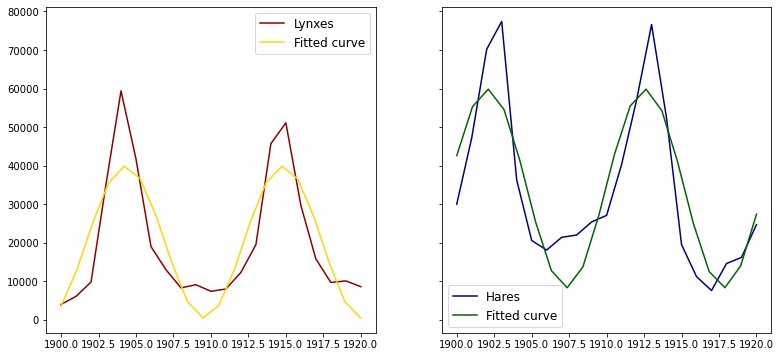

The period for the lynxes and the hares population is respectively 10.5 and 10.5 years.


In [25]:
params_l, cov_params_l = optimize.curve_fit(period_l, y, l, p0 = [20000, 30000, 0])
params_h, cov_params_h = optimize.curve_fit(period_h, y, h, p0 = [20000, 25000, 0])

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 6), sharey=True)
ax0.plot(y, l, label="Lynxes", color="darkred")
ax1.plot(y, h, label="Hares", color="navy")
ax0.plot(day, period_l(day, *params_l), 'gold', label = 'Fitted curve')
ax1.plot(day, period_h(day, *params_h), 'darkgreen', label = 'Fitted curve')
ax0.legend(prop={'size': 12}, loc = 'best')
ax1.legend(prop={'size': 12}, loc = 'best')
         
plt.show()
print('The period for the lynxes and the hares population is respectively {} and {} years.'.format(h_period*0.5, l_period*0.5))

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

Text(0.5, 1.0, 'Original image')

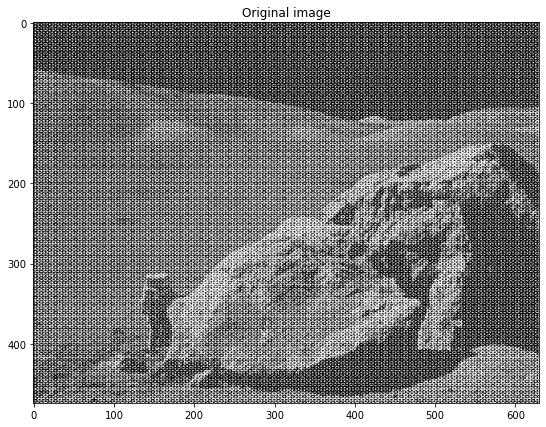

In [108]:
ml = plt.imread('moonlanding.png').astype(float)

plt.figure(figsize = (12,7))
plt.imshow(ml, plt.cm.gray)
plt.title('Original image')

Text(0.5, 1.0, 'Fourier transform')

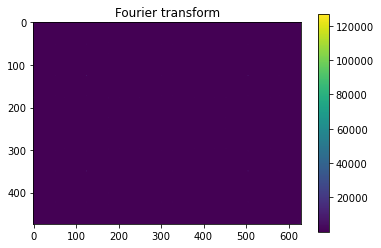

In [114]:
ml_fft = fftpack.fft2(ml)
plt.imshow(np.abs(ml_fft))
plt.colorbar()
plt.title('Fourier transform')

By plotting the spectrum we observe that on this scale we can't visualize anything, since the lower value that can be visualized is 10000. One idea could be to use a logarithmic scale:

Text(0.5, 1.0, 'Fourier transform')

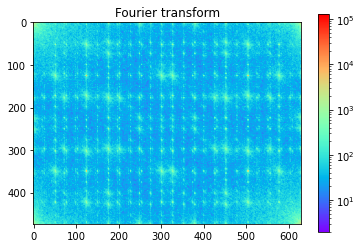

In [66]:
from matplotlib.colors import LogNorm
plt.imshow(np.abs(ml_fft), norm=LogNorm(vmin=2), cmap = 'rainbow')
plt.colorbar()
plt.title('Fourier transform')

In [67]:
ml_fft.shape

(474, 630)

In [115]:
ml_fft[np.abs(ml_fft) >= 2500] = 0

Text(0.5, 1.0, 'Filtered Spectrum')

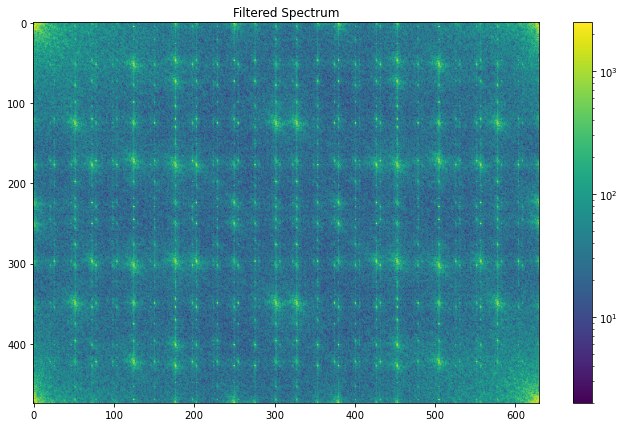

In [117]:
plt.figure(figsize = (12,7))
plt.imshow(np.abs(ml_fft), norm=LogNorm(vmin=2))
plt.colorbar()
plt.title('Filtered Spectrum')

Text(0.5, 1.0, 'Original image')

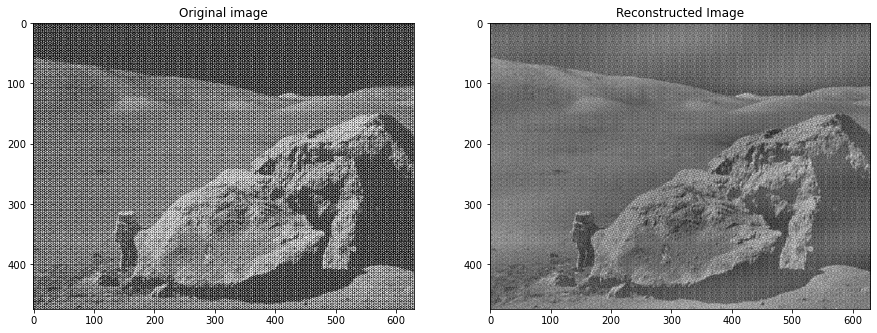

In [116]:
im_new = fftpack.ifft2(ml_fft).real
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,8))
ax2.imshow(im_new, plt.cm.gray)
ax2.set_title('Reconstructed Image')
ax1.imshow(ml, plt.cm.gray)
ax1.set_title('Original image')